In [ ]:
!pip install -q kaggle
from google.colab import files
upload = files.upload()

import os

# Make the Kaggle directory
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
# Move the kaggle.json file to the created directory
!cp kaggle.json ~/.kaggle/
# Set permissions for the file
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/isic-2019
import zipfile
# Ensure the file exists before trying to unzip
if os.path.exists('isic-2019.zip'):
    with zipfile.ZipFile('isic-2019.zip', 'r') as zip_ref:
        zip_ref.extractall('data')
else:
    print("Zip file not found!")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/isic-2019
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 9.10G/9.10G [07:29<00:00, 19.9MB/s]
100% 9.10G/9.10G [07:29<00:00, 21.7MB/s]


In [ ]:
!pip install efficientnet-pytorch
from efficientnet_pytorch import EfficientNet

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

In [ ]:
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
from sklearn.model_selection import train_test_split


In [ ]:
# Load the datasets
ground_truth = pd.read_csv('data/ISIC_2019_Training_GroundTruth.csv')
metadata = pd.read_csv('data/ISIC_2019_Training_Metadata.csv')

# Merge the DataFrames based on the 'image' column
merge_df = pd.merge(ground_truth, metadata, on='image').drop('lesion_id', axis=1)

# Identify the columns corresponding to each diagnosis
diagnosis_cols = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']

# Create a map from column names to numeric targets
target_map = {
    'MEL': 0,
    'NV': 1,
    'BCC': 2,
    'AK': 3,
    'BKL': 4,
    'DF': 5,
    'VASC': 6,
    'SCC': 7,
    'UNK': 8
}

# Create a map from numeric targets to human-readable diagnosis
diagnosis_map = {
    0: 'Melanoma',
    1: 'Melanocytic nevus',
    2: 'Basal cell carcinoma',
    3: 'Actinic keratosis',
    4: 'Benign keratosis',
    5: 'Dermatofibroma',
    6: 'Vascular lesion',
    7: 'Squamous cell carcinoma',
    8: 'Unknown'
}

# Create a target column by finding the column with the maximum value in each row and mapping to numeric values
merge_df['target'] = merge_df[diagnosis_cols].idxmax(axis=1).map(target_map)

# Map the numeric target column to the diagnosis
merge_df['diagnosis'] = merge_df['target'].map(diagnosis_map)

# Select relevant columns
df = merge_df.loc[:, ['image', 'target', 'diagnosis']]

# Create the path to the images
df['images'] = 'data/ISIC_2019_Training_Input/ISIC_2019_Training_Input/' + df['image'] + '.jpg'

# Optionally, replace certain anatom_site_general values
#df['anatom_site_general'] = merge_df['anatom_site_general'].replace(['lateral torso', 'anterior torso', 'posterior torso'], 'torso')

# Display the first few rows
print(df.head())


          image  target          diagnosis  \
0  ISIC_0000000       1  Melanocytic nevus   
1  ISIC_0000001       1  Melanocytic nevus   
2  ISIC_0000002       0           Melanoma   
3  ISIC_0000003       1  Melanocytic nevus   
4  ISIC_0000004       0           Melanoma   

                                              images  
0  data/ISIC_2019_Training_Input/ISIC_2019_Traini...  
1  data/ISIC_2019_Training_Input/ISIC_2019_Traini...  
2  data/ISIC_2019_Training_Input/ISIC_2019_Traini...  
3  data/ISIC_2019_Training_Input/ISIC_2019_Traini...  
4  data/ISIC_2019_Training_Input/ISIC_2019_Traini...  


In [ ]:
# Custom Dataset Class
class MelanomaDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['images']
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        label = self.df.iloc[idx]['target']
        return image, label

# Data Augmentation and Normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Splitting the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Creating datasets and dataloaders
train_dataset = MelanomaDataset(train_df, transform=data_transforms['train'])
val_dataset = MelanomaDataset(val_df, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=12)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=12)


In [ ]:
class MelanomaModel(nn.Module):
    def __init__(self, out_size, dropout_prob=0.5):
        super(MelanomaModel, self).__init__()
        self.efficient_net = EfficientNet.from_pretrained('efficientnet-b0')
        self.efficient_net._fc = nn.Identity()  # Remove the original fully connected layer
        self.fc1 = nn.Linear(1280, 512)  # EfficientNet-b0 output features
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, out_size)
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer
        self.loss_fn = nn.CrossEntropyLoss()  # Assuming classification task

    def forward(self, x):
        x = self.efficient_net(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    def training_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = self(images)  # Generate predictions
        loss = self.loss_fn(out, labels)  # Calculate loss
        acc = (out.argmax(1) == labels).float().mean()  # Calculate accuracy
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            out = self(images)  # Generate predictions
            loss = self.loss_fn(out, labels)  # Calculate loss
            acc = (out.argmax(1) == labels).float().mean()  # Calculate accuracy
        return {'val_loss': loss.item(), 'val_acc': acc.item()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = sum(batch_losses) / len(batch_losses)
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = sum(batch_accs) / len(batch_accs)
        return {'val_loss': epoch_loss, 'val_acc': epoch_acc}

    def epoch_end(self, epoch, result, train_loss, train_acc):
        print(f"Epoch [{epoch+1}]")
        print(f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}")
        print(f"val_loss  : {result['val_loss']:.4f}, val_acc  : {result['val_acc']:.4f}")
        print("")

# Instantiate model
num_classes = 9  # Access the original dataset's classes attribute
model = MelanomaModel(out_size=num_classes, dropout_prob=0.5)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Using scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Early stopping parameters
patience = 5
best_loss = float('inf')
counter = 0

def fit(epochs, model, train_loader, val_loader, optimizer, scheduler):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_accs = []
        for batch in train_loader:
            optimizer.zero_grad()
            loss, acc = model.training_step(batch)
            train_losses.append(loss.item())
            train_accs.append(acc.item())
            loss.backward()
            optimizer.step()

        train_loss = sum(train_losses) / len(train_losses)
        train_acc = sum(train_accs) / len(train_accs)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        model.eval()

        val_outputs= [model.validation_step(batch) for batch in val_loader]
        result = model.validation_epoch_end(val_outputs)
        history['val_loss'].append(result['val_loss'])
        history['val_acc'].append(result['val_acc'])
        model.epoch_end(epoch, result, train_loss, train_acc)
        scheduler.step(result['val_loss'])


    return history

history = fit(30, model, train_loader, val_loader, optimizer, scheduler)

Loaded pretrained weights for efficientnet-b0
Epoch [1]
train_loss: 1.1913, train_acc: 0.5923
val_loss  : 0.9086, val_acc  : 0.6860

Epoch [2]
train_loss: 0.9651, train_acc: 0.6618
val_loss  : 0.8233, val_acc  : 0.7122

Epoch [3]
train_loss: 0.8895, train_acc: 0.6868
val_loss  : 0.7344, val_acc  : 0.7454

Epoch [4]
train_loss: 0.8404, train_acc: 0.7027
val_loss  : 0.7130, val_acc  : 0.7483

Epoch [5]
train_loss: 0.7901, train_acc: 0.7193
val_loss  : 0.6919, val_acc  : 0.7507

Epoch [6]
train_loss: 0.7630, train_acc: 0.7279
val_loss  : 0.6623, val_acc  : 0.7691

Epoch [7]
train_loss: 0.7420, train_acc: 0.7369
val_loss  : 0.6545, val_acc  : 0.7693

Epoch [8]
train_loss: 0.7099, train_acc: 0.7459
val_loss  : 0.6266, val_acc  : 0.7782

Epoch [9]
train_loss: 0.6811, train_acc: 0.7569
val_loss  : 0.6110, val_acc  : 0.7884

Epoch [10]
train_loss: 0.6729, train_acc: 0.7619
val_loss  : 0.5828, val_acc  : 0.7939

Epoch [11]
train_loss: 0.6346, train_acc: 0.7734
val_loss  : 0.5769, val_acc  : 0.7

In [ ]:
from google.colab import drive
import torch

# Mount Google Drive
drive.mount('/content/drive')

# Save the model architecture and weights to Google Drive
file_path = '/content/drive/My Drive/multi_weight.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'architecture': model
}, file_path)

print("Model and weights have been saved to Google Drive:", file_path)

Mounted at /content/drive
Model and weights have been saved to Google Drive: /content/drive/My Drive/multi_weight.pth


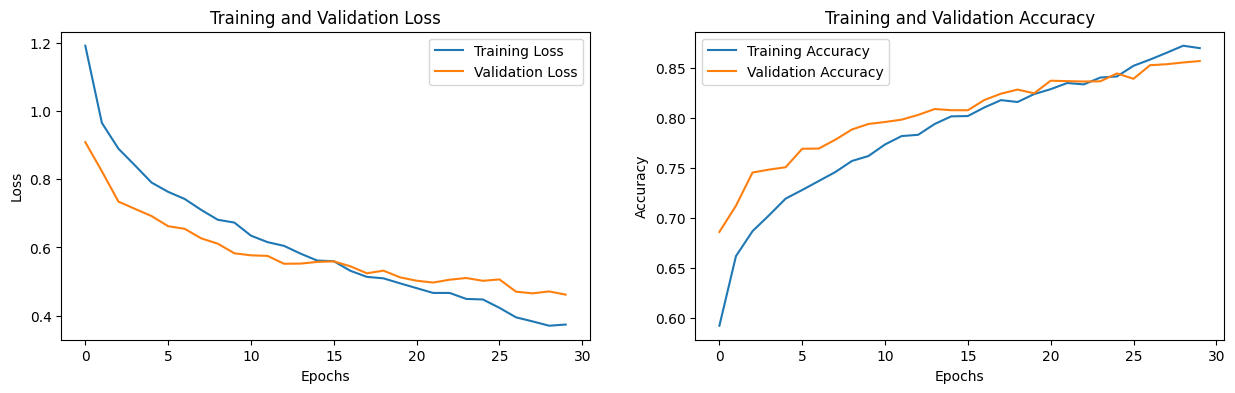

In [ ]:
# Plotting the training and validation loss and accuracy
def plot_history(history):
    epochs = range(len(history['train_loss']))

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()

plot_history(history)

In [ ]:
history = fit(10, model, train_loader, val_loader, optimizer, scheduler)

Epoch [1]
train_loss: 0.3704, train_acc: 0.8719
val_loss  : 0.4618, val_acc  : 0.8591

Epoch [2]
train_loss: 0.3625, train_acc: 0.8717
val_loss  : 0.4734, val_acc  : 0.8583

Epoch [3]
train_loss: 0.3651, train_acc: 0.8715
val_loss  : 0.4680, val_acc  : 0.8587

Epoch [4]
train_loss: 0.3570, train_acc: 0.8723
val_loss  : 0.4660, val_acc  : 0.8603

Epoch [5]
train_loss: 0.3555, train_acc: 0.8760
val_loss  : 0.4671, val_acc  : 0.8613

Epoch [6]
train_loss: 0.3452, train_acc: 0.8767
val_loss  : 0.4660, val_acc  : 0.8597

Epoch [7]
train_loss: 0.3473, train_acc: 0.8770
val_loss  : 0.4666, val_acc  : 0.8601

Epoch [8]
train_loss: 0.3526, train_acc: 0.8739
val_loss  : 0.4637, val_acc  : 0.8613

Epoch [9]
train_loss: 0.3441, train_acc: 0.8795
val_loss  : 0.4648, val_acc  : 0.8613

Epoch [10]
train_loss: 0.3489, train_acc: 0.8767
val_loss  : 0.4622, val_acc  : 0.8629



In [ ]:
history = fit(5, model, train_loader, val_loader, optimizer, scheduler)

Epoch [1]
train_loss: 0.3517, train_acc: 0.8750
val_loss  : 0.4670, val_acc  : 0.8615

Epoch [2]
train_loss: 0.3474, train_acc: 0.8791
val_loss  : 0.4653, val_acc  : 0.8601

Epoch [3]
train_loss: 0.3466, train_acc: 0.8780
val_loss  : 0.4647, val_acc  : 0.8601

Epoch [4]
train_loss: 0.3530, train_acc: 0.8739
val_loss  : 0.4630, val_acc  : 0.8613

Epoch [5]
train_loss: 0.3462, train_acc: 0.8777
val_loss  : 0.4654, val_acc  : 0.8611



In [ ]:
history = fit(5, model, train_loader, val_loader, optimizer, scheduler)

Epoch [1]
train_loss: 0.3421, train_acc: 0.8810
val_loss  : 0.4634, val_acc  : 0.8617

Epoch [2]
train_loss: 0.3467, train_acc: 0.8795
val_loss  : 0.4642, val_acc  : 0.8605

Epoch [3]
train_loss: 0.3515, train_acc: 0.8754
val_loss  : 0.4661, val_acc  : 0.8605

Epoch [4]
train_loss: 0.3414, train_acc: 0.8780
val_loss  : 0.4651, val_acc  : 0.8611

Epoch [5]
train_loss: 0.3572, train_acc: 0.8760
val_loss  : 0.4634, val_acc  : 0.8613



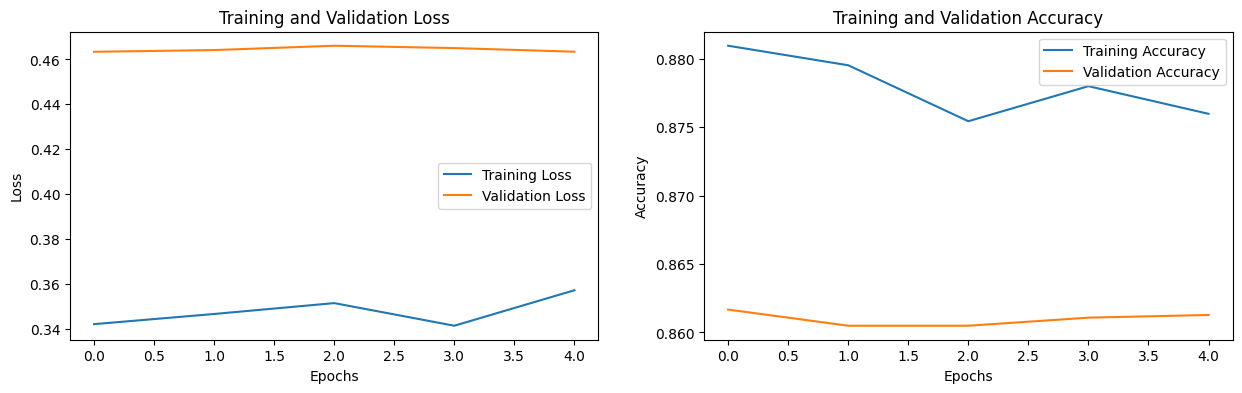

In [ ]:
# Plotting the training and validation loss and accuracy
def plot_history(history):
    epochs = range(len(history['train_loss']))

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()

plot_history(history)

In [ ]:
from google.colab import drive
import torch

# Mount Google Drive
drive.mount('/content/drive')

# Save the model architecture and weights to Google Drive
file_path = '/content/drive/My Drive/multi_weight2.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'architecture': model
}, file_path)

print("Model and weights have been saved to Google Drive:", file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model and weights have been saved to Google Drive: /content/drive/My Drive/multi_weight2.pth
